# 在 Paddle Quantum 中模拟含噪量子电路

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 噪声简介

在理想模型中，我们通常假设量子电路是在一个**封闭系统**中执行的。然而在真实的量子设备中，系统会通过和环境的相互作用产生**非相干噪声（incoherent noise）**。在近期的量子设备上，噪声的影响是难以忽略的。因此，如何设计在噪声影响下依然鲁棒（robust）的量子算法对于量子计算的实用化来说是至关重要的。利用 Paddle Quantum 中的噪声模块，我们现在可以在设计并模拟量子算法的同时研究噪声对其的影响，从而进一步的探索对应的错误缓释（error mitigation）方案。

## Paddle Quantum 中的噪声建模

### 噪声模型与量子信道

对于一个封闭的量子系统，其演化总是幺正（unitary）的。数学上，我们通常用酉变换的语言来描述一个参数化量子电路 $U(\vec{\theta})$ 的作用， 

$$
\rho \longrightarrow U(\vec{\theta}) \rho U^\dagger(\vec{\theta}),
\tag{1}
$$

其中 $\rho$ 表示初始量子态， $\vec{\theta}$ 表示电路的参数向量。那么最简单的一类噪声模型，是我们在控制量子系统执行具体逻辑门的时候参数的噪声化，

$$
\rho \longrightarrow U(\vec{\theta}+\vec{\epsilon}) \rho U^\dagger(\vec{\theta}+\vec{\epsilon}),
\tag{2}
$$

其中 $\vec{\epsilon}$ 可以是从高斯分布中采样出的白噪声。这样的噪声被称为**相干噪声（coherent noise）**，通常是由于硬件系统没有校准或者量子控制层面的误差。在某些特定情况下，相干噪声会比非相干噪声更具有破坏性 [1]。此外，值得注意的是相干噪声的建模也是用酉变换的语言 $U(\vec{\epsilon})$ 来描述的。

相比于相干噪声，人们更为关注的问题是**开放系统**中的产生的非相干噪声，这样一个系统的演化往往是非幺正（non-unitary）的。这种情况下，我们需要通过一个更广义的映射来描述系统的演化，即 $\rho \longrightarrow \mathcal{E}(\rho)$，这种映射也被称之为一个**量子信道（quantum channel）**。为了方便讨论，我们这里采用 *operator-sum representation* [2] 将一个量子信道表示为

$$
\mathcal{E}(\rho) =  \sum_{k=0}^{m-1} E_k \rho E_k^{\dagger},
\tag{3}
$$

其中 $\{E_k\}$ 被称为 *Kraus* 算符，同时还满足完备性条件 $\sum_k E_k^\dagger E_k = I$。注意到，量子信道数学上是 completely positive 和 trace-preserving 的。


利用这种表示方法，我们可以直观的理解非相干噪声是如何影响量子态的：对于一个一开始处于纯态 $\rho = |\psi\rangle\langle \psi|$ 的量子系统，经过一个噪声量子信道（例如 $m = 2$ ）时，我们将得到一个混态 $\mathcal{E}(\rho) = E_0 \rho E_0^\dagger + E_1 \rho E_1^\dagger$。以简单的单个量子比特上的比特反转（bit flip）噪声为例，其表达形式为

$$
\mathcal{E}_{BF}(\rho) = (1 - p) I \rho I+ p X \rho X,
\tag{4}
$$

其中 $X,I$ 是泡利矩阵。 对应的 *Kruas* 算符为：

$$
E_0 = \sqrt{1-p}
\begin{bmatrix}
1 &0 \\
0& 1 
\end{bmatrix},
E_1 = \sqrt{p}
\begin{bmatrix}
0& 1 \\
1&0
\end{bmatrix}.
\tag{5}
$$

该信道的物理含义可以理解为存在 $p$ 的概率将 $|0\rangle$ 态反转到 $|1\rangle$ 态上，反之亦然。在 Paddle Quantum 中，可以通过 `UAnsatz.bit_flip(p, which_qubit)` 来添加该信道，其中 `p` 代表噪声大小。

**注释：** 对于一个量子信道，其 *Kraus* 算符表示未必是唯一的 [3]。

### Paddle Quantum 中添加信道的方式

接下来我们以比特反转信道为例，展示如何用 Paddle Quantum 中的噪声模块来实现对噪声的模拟。首先，将一个量子比特初始化为 $|0\rangle$ 态。

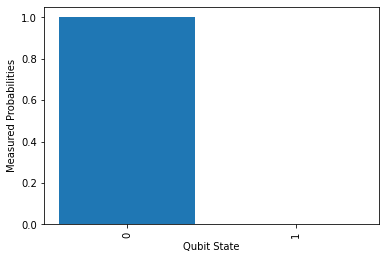

{'0': 1024}

In [1]:
import paddle
from paddle_quantum.circuit import UAnsatz

# 设置量子比特数
num_qubits = 1

# 初始化量子电路
cir = UAnsatz(num_qubits)

# 制备 |0> 态
init_state = cir.run_density_matrix()

# 进行计算基上测量，默认 shots=1024
cir.measure(plot=True)

之后，我们加上一个 $p=0.1$ 的比特反转噪声，并测量通过信道之后的量子比特。 
**注释：** 噪声信道只支持在 density matrix 模式下运行。

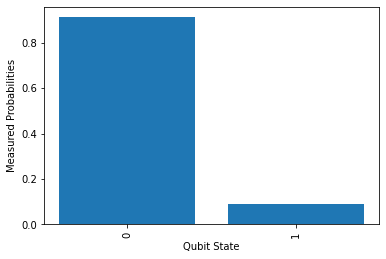

经过了 bit flip 信道之后的量子态是：
 [[0.9+0.j 0. +0.j]
 [0. +0.j 0.1+0.j]]


In [2]:
# 噪声水平
p = 0.1

# 添加比特反转信道
cir.bit_flip(p, 0)

# 执行电路
# 注释：噪声信道只能在 density matrix 模式下运行
fin_state = cir.run_density_matrix()

# 测量结果
cir.measure(plot=True)
print('经过了 bit flip 信道之后的量子态是：\n', fin_state.numpy())

可以看到，经过了比特反转信道（概率为 $p=0.1$）之后的量子态变成了混合态 $0.9 | 0 \rangle \langle 0 | + 0.1 | 1 \rangle \langle 1 |$。



### 常用噪声信道

除了比特反转信道之外，Paddle Quantum 也支持模拟其他常用的噪声信道。


- **相位反转信道（phase flip channel）**

  与比特反转信道类似，相位反转信道会以 $p$ 的概率来反转一个量子比特的相位，其表达形式为
  
  $$
  \mathcal{E}_{PF}(\rho) =  (1 - p) \rho + p Z \rho Z.
  \tag{6}
  $$


- **比特相位反转信道（bit-phase flip channel）**

  $$
  \mathcal{E}_{BPF}(\rho) = (1-p) \rho + p Y \rho Y.
  \tag{7}
  $$


- **去极化信道 （depolarizing channel）**

  通过去极化信道之后，将会有 $p$ 的概率处于最大混态 $I/2$ 和 $1-p$ 的概率维持不变。可以表示为对称地施加泡利噪声，
  
  $$
  \mathcal{E}_{D}(\rho) = (1 - p) \rho + \frac{p}{3}
  \left( X \rho X+ Y \rho Y + Z \rho Z \right).
  \tag{8}
  $$


- **泡利信道（Pauli channel）**

    该信道会以非对称的形式施加泡利噪声。表达形式为
  
  $$
  \mathcal{E}_{Pauli}(\rho) = (1 - p_x - p_y - p_z) \rho + p_x X \rho X + p_y Y \rho Y + p_z Z \rho Z.
  \tag{9}
  $$


- **振幅阻尼信道（amplitude damping channel）**

  振幅阻尼信道可以用来模拟当系统受到**能量耗散**时引入的噪声。表达形式为，
  
  $$
  \mathcal{E}_{AD}(\rho) = E_0 \rho E_0^\dagger + E_1 \rho E_1^\dagger,
  \tag{10}
  $$
  
  其中 $\gamma$ 表示耗散系数，
  
  $$
  E_0 = 
  \begin{bmatrix}
   1 & 0 \\ 0 & \sqrt{1 - \gamma}
  \end{bmatrix},
  E_1 = 
  \begin{bmatrix}
   0 & \sqrt{\gamma} \\ 0 & 0
  \end{bmatrix}.
  \tag{11}
  $$ 


- **相位阻尼信道（phase damping channel）**

  相位阻尼信道描述的是当系统没有与外界环境交换能量，却损失了**量子信息**的情况下的噪声模型。其表达形式为
  
  $$
  \mathcal{E}_{PD}(\rho) = E_0 \rho E_0^\dagger + E_1 \rho E_1^\dagger,
  \tag{12}
  $$
  
  其中 $\gamma$ 表示损失系数，
  
  $$
  E_0 = 
  \begin{bmatrix}
   1 & 0 \\ 0 & \sqrt{1 - \gamma}
  \end{bmatrix}, 
  E_1 = 
  \begin{bmatrix}
   0 & 0 \\ 0 & \sqrt{\gamma}
  \end{bmatrix}.
  \tag{13}
  $$


- **广义振幅阻尼信道（generalized amplitude Damping channel）**

  该信道描述的是系统与外界环境在**有限温度下交换能量**的噪声模型，同时也是**超导量子计算中的常见噪声** [4]。其表达形式较为复杂，感兴趣的读者可以进一步的阅读 [API 文档](https://qml.baidu.com/api/paddle_quantum.circuit.uansatz.html) 和相应的参考文献。


**注释：** 在 Paddle Quantum 中，我们可以通过 `UAnsatz.phase_flip()`，`UAnsatz.bit_phase_flip()`， `UAnsatz.depolarizing()`，`UAnsatz.pauli_channel()`, `UAnsatz.amplitude_damping()`，`UAnsatz.phase_damping()`以及 `UAnsatz.generalized_amplitude_damping()` 来添加上述噪声。

**注释：** 通常会选择振幅阻尼信道和相位阻尼信道来建模实际量子设备中的噪声，因为这两种信道可以较好的描述真实量子系统中的物理过程（可以用来建模 $T_1$ 和 $T_2$ 噪声）。

### 自定义信道

此外，我们也可以通过 `UAnsatz.customized_channel()` 来向电路中添加自定义噪声。具体的，该方法支持用自定义的 *Kraus* 算符来建模任意的噪声模型，我们自定义的方式来搭建比特反转信道为例：

In [3]:
import paddle
import numpy as np
from paddle_quantum.circuit import UAnsatz

# 设置噪声参数
p = 0.1

# 我们用自定义的 Kraus 算符来描述一个比特反转信道
# 注意 Kraus 算符的数据类型应为 complex_128
e_0 = paddle.to_tensor(np.sqrt(1 - p) * np.array([[1, 0], [0, 1]], dtype='complex128'))
e_1 = paddle.to_tensor(np.sqrt(p) * np.array([[0, 1], [1, 0]], dtype='complex128'))
Kraus_ops = [e_0, e_1]

# 初始化量子电路
num_qubits = 1
cir = UAnsatz(num_qubits)

# 添加自定义噪声，其输入为 Kraus 算符的列表
cir.customized_channel(Kraus_ops, 0)

# 执行电路
fin_state = cir.run_density_matrix()

# 比较结果
cir_1 = UAnsatz(num_qubits)
cir_1.bit_flip(p, 0)
fin_state_1 = cir_1.run_density_matrix()
print('经过了自定义信道之后的量子态是：\n', fin_state.numpy())
print('\n经过了比特反转信道之后的量子态是：\n', fin_state_1.numpy())
print('\n两个态是否相同？', bool((fin_state - fin_state_1).abs().sum() < 1e-8))

经过了自定义信道之后的量子态是：
 [[0.9+0.j 0. +0.j]
 [0. +0.j 0.1+0.j]]

经过了比特反转信道之后的量子态是：
 [[0.9+0.j 0. +0.j]
 [0. +0.j 0.1+0.j]]

两个态是否相同？ True


按照上述例子，用户可以通过自定义 *Kraus* 算符的方式实现特定的信道。

## 拓展：Paddle Quantum 模拟含噪纠缠资源


许多重要的量子技术，例如量子隐形传态、态转换、分布式量子计算等都需要纠缠资源的预先分配。以纠缠量子比特对为例，在理想情况下，我们希望分配的纠缠资源处于**最大纠缠态**（maximally entangled state)。但是在实际的应用中，纠缠资源往往在制备、传输以及保存的过程中会和环境发生相互作用，从而引入噪声。下面，我们用 Paddle Quantum 中的去极化信道来模拟一个简单的场景，白噪声对贝尔态的影响：

In [4]:
import paddle
from paddle import matmul, trace
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.state import bell_state

# 噪声参数
p_trans = 0.1
p_store = 0.01

# 创建用来模拟噪声的量子电路
num_qubits = 2
cir = UAnsatz(num_qubits)

# 这里的初态是制备好的贝尔态
init_state = paddle.to_tensor(bell_state(2))

# 分别在两个量子比特上添加去极化信道，表示在传输过程中引入的噪声
cir.depolarizing(p_trans, 0)
cir.depolarizing(p_trans, 1)

# 用模拟噪声的电路来演化该初态
status_mid = cir.run_density_matrix(init_state)

# 分别在两个量子比特上添加振幅阻尼信道，表示在保存过程中引入的噪声
cir.amplitude_damping(p_store, 0)
cir.amplitude_damping(p_store, 1)

# 用模拟噪声的电路来演化该初态
status_fin = cir.run_density_matrix(status_mid)
fidelity_mid = paddle.real(trace(matmul(init_state, status_mid)))
fidelity_fin = paddle.real(trace(matmul(init_state, status_fin)))

print("初态和贝尔态之间的保真度为", 1)
print("经过了传输（去极化信道）之后的纠缠对和贝尔态的保真度为 {:.5f}".format(fidelity_mid.numpy()[0]))
print("又经过了存储（振幅阻尼信道）之后的纠缠对和贝尔态的保真度为 {:.5f}".format(fidelity_fin.numpy()[0]))

初态和贝尔态之间的保真度为 1
经过了传输（去极化信道）之后的纠缠对和贝尔态的保真度为 0.81333
又经过了存储（振幅阻尼信道）之后的纠缠对和贝尔态的保真度为 0.66752


**注释：** 在 [纠缠蒸馏](../locc/EntanglementDistillation_LOCCNET_CN.ipynb) 的教程中我们介绍了如何利用 Paddle Quantm 中的 LoccNet 模块来研究纠缠蒸馏，即利用多个含噪声的纠缠对来提取高保真度的纠缠对，感兴趣的读者可以前往阅读。

## 应用： Paddle Quantum 模拟含噪变分量子本征求解器（VQE）


变分量子本征求解器（variational quantum eigensolver, VQE）[5] 可以用变分量子电路来计算某个给定哈密顿量的基态能量，关于其具体的原理和背景在之前的教程 [变分量子本征求解器](../quantum_simulation/VQE_CN.ipynb) 中有详细的讲解，感兴趣的读者可以前往阅读。

在这里，我们尝试用一个简单的 VQE 电路来求解如下哈密顿量的基态能量：

$$ 
H = 0.4 \, Z \otimes I + 0.4 \, I \otimes Z + 0.2 \, X \otimes X. 
\tag{14}
$$

特别地，我们将在电路中引入振幅阻尼信道来模拟电路运行时的 $T_1$ 噪声，让我们分别来看一下含噪电路和非含噪电路在该任务上的表现：

In [5]:
import numpy as np
import paddle
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix

# 首先生成泡利字符串表示下的哈密顿量
H_info = [[0.4, 'z0'], [0.4, 'z1'], [0.2, 'x0,x1']]

# 把记录的关于哈密顿量的信息转化为矩阵表示
H_matrix = pauli_str_to_matrix(H_info, num_qubits)

# 超参数设置
num_qubits = 2
theta_size = 4
ITR = 100
LR = 0.4
SEED = 999    
p = 0.1

In [6]:
class vqe_noisy(paddle.nn.Layer):
    
    def __init__(self, shape, dtype='float64'):
        super(vqe_noisy, self).__init__()
        
        # 初始化一个长度为theta_size的可学习参数列表，并用[0, 2*pi]的均匀分布来填充初始值
        self.theta = self.create_parameter(shape=shape, 
                                           default_initializer=paddle.nn.initializer.Uniform(low=0., high=2*np.pi), 
                                           dtype=dtype, is_bias=False)
        
    # 定义损失函数和前向传播机制
    def forward(self):
        
        # 初始量子电路
        cir = UAnsatz(num_qubits)
        
        # 添加参数化量子电路
        cir.ry(self.theta[0], 0)
        cir.ry(self.theta[1], 1)
        
        cir.cnot([0, 1])
        
        cir.ry(self.theta[2], 0)
        cir.ry(self.theta[3], 1)
        
        # 添加振幅阻尼 AD 噪声
        cir.amplitude_damping(p, 0)
        cir.amplitude_damping(p, 1)
        
        # 运行密度矩阵模式
        cir.run_density_matrix()
        
        # 关于观测量 H_info 的期望值
        loss = cir.expecval(H_info)
        
        return loss
    
# 创建一个不含噪声的 VQE 电路
class vqe_noise_free(paddle.nn.Layer):
    
    def __init__(self, shape, dtype='float64'):
        super(vqe_noise_free, self).__init__()
        
        self.theta = self.create_parameter(shape=shape, 
                                           default_initializer=paddle.nn.initializer.Uniform(low=0., high=2*np.pi), 
                                           dtype=dtype, is_bias=False)
        
    def forward(self):
        
        cir = UAnsatz(num_qubits)
        cir.ry(self.theta[0], 0)
        cir.ry(self.theta[1], 1) 
        cir.cnot([0, 1])
        cir.ry(self.theta[2], 0)
        cir.ry(self.theta[3], 1)
        cir.run_density_matrix()
        loss = cir.expecval(H_info)
        
        return loss
    
# 训练含噪 VQE 电路
print('========== Training Noisy VQE ==========')
loss_list = []
parameter_list = []

# 定义参数维度
vqe = vqe_noisy([theta_size])

# 一般来说，我们利用Adam优化器来获得相对好的收敛，当然你可以改成SGD或者是RMS prop.
opt = paddle.optimizer.Adam(learning_rate = LR, parameters = vqe.parameters())    

# 优化循环
for itr in range(ITR):

    # 前向传播计算损失函数
    loss = vqe()

    # 反向传播极小化损失函数
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()

    # 记录学习曲线
    loss_list.append(loss.numpy()[0])
    parameter_list.append(vqe.parameters()[0].numpy())
    if itr % 10 == 0:
        print('iter:', itr, '  loss: %.4f' % loss.numpy())
        
# 用同样的方式训练不含噪的 VQE 电路
print('========== Training Noise Free VQE ==========')
loss_list_no_noise = []
parameter_list_no_noise = []

vqe_no_noise = vqe_noise_free([theta_size])
opt_no_noise = paddle.optimizer.Adam(learning_rate = LR, parameters = vqe_no_noise.parameters())    

for itr in range(ITR):

    loss = vqe_no_noise()

    loss.backward()
    opt_no_noise.minimize(loss)
    opt_no_noise.clear_grad()

    loss_list_no_noise.append(loss.numpy()[0])
    parameter_list_no_noise.append(vqe_no_noise.parameters()[0].numpy())
    if itr % 10 == 0:
        print('iter:', itr, '  loss: %.4f' % loss.numpy())


print('\n含噪电路计算得到的基态能量是: ', loss_list[-1], "Ha")
print('不含噪电路计算得到的基态能量是: ', loss_list_no_noise[-1], "Ha")
print('真实的基态能量为: ', np.linalg.eigh(H_matrix)[0][0], "Ha")

========== Training Noisy VQE ==========
iter: 0   loss: -0.0782
iter: 10   loss: -0.6395
iter: 20   loss: -0.6548
iter: 30   loss: -0.6547
iter: 40   loss: -0.6591
iter: 50   loss: -0.6608
iter: 60   loss: -0.6618
iter: 70   loss: -0.6621
iter: 80   loss: -0.6621
iter: 90   loss: -0.6621
========== Training Noise Free VQE ==========
iter: 0   loss: 0.1521
iter: 10   loss: -0.7413
iter: 20   loss: -0.8208
iter: 30   loss: -0.8170
iter: 40   loss: -0.8169
iter: 50   loss: -0.8241
iter: 60   loss: -0.8238
iter: 70   loss: -0.8245
iter: 80   loss: -0.8245
iter: 90   loss: -0.8246

含噪电路计算得到的基态能量是:  -0.6621559864367315 Ha
不含噪电路计算得到的基态能量是:  -0.8246026782552648 Ha
真实的基态能量为:  -0.8246211251235321 Ha


可以看到，含噪的变分量子本征求解器的效果要差于不含噪的版本，无法达到化学精度的要求 $\varepsilon = 0.0016$ Ha。

## 总结

噪声是 NISQ 时代量子设备的一个不可忽视的特征。在近期的量子技术中，我们有必要将噪声考虑进计算模型中。因此，设计对于噪声鲁棒的量子算法，乃至于设计噪声抑制方案，都是 NISQ 时代的一大重要方向。基于 Paddle Quantum 新增的噪声模块，我们希望为开发者提供贴近真实系统的近期量子计算应用的开发平台，帮助使用者一起思考如何更好地使用含噪量子设备以及如何设计出更鲁棒的量子算法，进而更好地通过近期量子设备实现人工智能、量子化学等领域的应用。


---

## 参考文献

[1] Iverson, J. K., & Preskill, J. Coherence in logical quantum channels. [New Journal of Physics, 22(7), 073066 (2020).](https://iopscience.iop.org/article/10.1088/1367-2630/ab8e5c)

[2] Nielsen, M. A. & Chuang, I. L. Quantum computation and quantum information. Cambridge university press (2010).

[3] Preskill, J. Quantum Information Lecture Notes. Chapter 3 (2018).

[4] Chirolli, L., & Burkard, G. Decoherence in solid-state qubits. [Advances in Physics, 57(3), 225-285 (2008).](https://www.tandfonline.com/doi/abs/10.1080/00018730802218067)

[5] Peruzzo, A. et al. A variational eigenvalue solver on a photonic quantum processor. [Nat. Commun. 5, 4213 (2014).](https://www.nature.com/articles/ncomms5213)